- In this notebook, I trained the RNet, which is the second part of the model
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## Read RNet txt file
- In this part, it reads the txt file generated from the step 2.
- The format of the txt file is:
        image_path * label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 * \n
- The output of this function is in the format:
        [image_path,[label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2], ... , [label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2]]

In [3]:
def create_rnet_data_txt_parser(txt_path, img_dir,num_data=5000):

    if osp.exists(txt_path):
        img_faces = []
        with open(txt_path, 'r') as f:
            l = []
            lines = list(map(lambda line: line.strip().split('\n'), f))
            lines = [i[0] for i in lines]   
            shuffle(lines)
            img_count=0
            for line in lines:     
                if num_data is not None and img_count>=num_data:
                    break
                img_label_gt_crop=line.split('*')  
                real_img_path=img_label_gt_crop[0]
                label_gt_crop=[i.split(',') for i in img_label_gt_crop[1].split('+')]

                if osp.exists(real_img_path):
                    try:
                        Image.open(real_img_path).verify()
                        img_faces.append([real_img_path, label_gt_crop]) 
                        img_count+=1
                        
                    except:
                        print("*** warning:cannot open",real_img_path)

                else:
                    print("*** warning:image path invalid",real_img_path)

                

        return img_faces
    else:
        print('*** warning:WILDER_FACE txt file not exist!')


## Create the Inplace Dataset for RNet
- The input of this part is generated from the **create_rnet_data_txt_parser** function

- The output of the **self.\__getitem \__ ** will be:
      (img_tensor, label, offset, landmark_flag, landmark)
      
- The **self.\__getitem \__ ** do the following things:  

    * It opens the corresponding image, and gets the figures of:
            label:            1 (if have face), 0 (else)
            ground truth boxes:  (gt_x1, gt_y1, gt_x2, gt_y2) 
            cropped boxes:      (cr_x1, cr_y1, cr_x2, cr_y2)
    * It randomly chooses a crop box from the list of crop boxes
    * It crops the image according to the seleted crop box
    * It calulated the offset of the crop box

In [4]:
class InplaceDataset(data.Dataset):
    def __init__(self,  img_faces, cropsize):
        
        def cal_offset(face, box):
            offset = [
                (face[0] - box[0]) / float(box[2] - box[0]),
                (face[1] - box[1]) / float(box[3] - box[1]),
                (face[2] - box[2]) / float(box[2] - box[0]),
                (face[3] - box[3]) / float(box[3] - box[1]),
                ]
            return offset  
        
        self.img_path=[]
        self.label_offset_crop=[]
        for img_face in img_faces:

            img_path=img_face[0]
            label_box_crop=[]
            
            for i in img_face[1]:
                try:
                    label=i[0]
                    label=[1.0 if label in ['p', 'pf', 'l'] else 0.0]
                    gt=[int(j) for j in i[1:5]]
                    crop_box=[int(j) for j in i[5:9]]
                    offset=cal_offset(gt, crop_box)
                    label_box_crop.append([label,offset,crop_box])
                except:
                    continue
            if len(label_box_crop) != 0:
                self.img_path.append(img_path)
                self.label_offset_crop.append(label_box_crop)
            else:
                print(img_path,'no box')

        self.crop_size = cropsize
        print('===> data set size:{}'.format(self.__len__()))       

       
      
    def __getitem__(self, index):
        
        img= np.array(Image.open(self.img_path[index]).convert('RGB'))
        label_box_crop=self.label_offset_crop[index]
        label,offset,crop_box=label_box_crop[random.randint(0,len(label_box_crop))]
        
        label=torch.FloatTensor(label)
        offset=torch.FloatTensor(offset)
        
        crop_img = img[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
        crop_img = Image.fromarray(crop_img, mode='RGB').resize((self.crop_size , self.crop_size ), resample=PIL.Image.BILINEAR)    
        img_tensor = transforms.ToTensor()(crop_img)     

        
        landmark_flag = torch.FloatTensor([0.0])
        landmark = torch.FloatTensor(10 * [0.0])
        
        return (img_tensor, label, offset, landmark_flag, landmark)

    def __len__(self):
        return len(self.img_path)

## RNet Model
Here show the structure of the RNet Model:

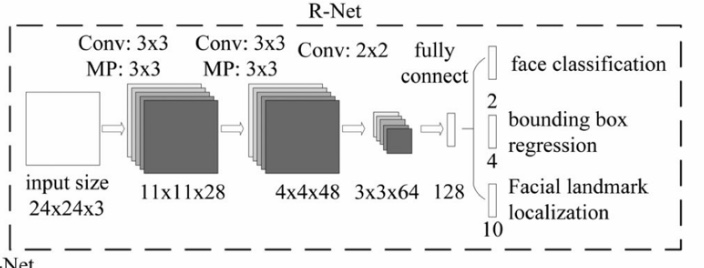

In [5]:
Image.open('RNet Model.jpg')

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)

class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            # 24x24x3
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            # 22x22x28
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            # 10x10x28
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            # 8x8x48
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            # 3x3x48
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  # conv3
            # 2x2x64
            nn.PReLU()  # prelu3
        )
        # 2x2x64
        self.conv4 = nn.Linear(64 * 2 * 2, 128)  # conv4
        # 128
        self.prelu4 = nn.PReLU()  # prelu4
        # detection
        self.conv5_1 = nn.Linear(128, 1)
        # bounding box regression
        self.conv5_2 = nn.Linear(128, 4)
        # lanbmark localization
        self.conv5_3 = nn.Linear(128, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        landmark = self.conv5_3(x)
        return det, box, landmark



## Training

In [8]:
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
train_txt_path='../input/rnet-train-txt/rnet_train_data.txt'
eval_txt_path='../input/rnet-train-txt/rnet_eval_data.txt'
train_img_path='../input/wider-data/WIDER/WIDER_train'
eval_img_path='../input/wider-data/WIDER/WIDER_val'
train_num=None
eval_num=None
class_data_augment = 3 
landmark_data_dir = None 
landmark_data_txt_path = None 
LR = 0.001
EPOCH = 60
BATCH_SIZE = 32
NUM_WORKS = 8
Rnet_loss_config = [1.0, 0.5, 0]

train_img_faces = create_rnet_data_txt_parser(train_txt_path,train_img_path ,num_data=train_num)
eval_img_faces = create_rnet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=eval_num)
train_IDS=InplaceDataset(train_img_faces, cropsize=24)
eval_IDS=InplaceDataset(eval_img_faces, cropsize=24)
Train_Loader=DataLoader(train_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
Eval_Loader=DataLoader(eval_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
train_num=len(train_IDS)
eval_num=len(eval_IDS)

net=R_Net().cuda()
for param in net.conv5_3.parameters():
    param.requires_grad = False

../input/wider-data/WIDER/WIDER_train/39--Ice_Skating/39_Ice_Skating_iceskiing_39_29.jpg no box
../input/wider-data/WIDER/WIDER_train/39--Ice_Skating/39_Ice_Skating_iceskiing_39_114.jpg no box
../input/wider-data/WIDER/WIDER_train/39--Ice_Skating/39_Ice_Skating_iceskiing_39_126.jpg no box
../input/wider-data/WIDER/WIDER_train/43--Row_Boat/43_Row_Boat_Rowboat_43_440.jpg no box
../input/wider-data/WIDER/WIDER_train/6--Funeral/6_Funeral_Funeral_6_1008.jpg no box
../input/wider-data/WIDER/WIDER_train/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_761.jpg no box
../input/wider-data/WIDER/WIDER_train/6--Funeral/6_Funeral_Funeral_6_279.jpg no box
../input/wider-data/WIDER/WIDER_train/12--Group/12_Group_Group_12_Group_Group_12_815.jpg no box
../input/wider-data/WIDER/WIDER_train/57--Angler/57_Angler_peoplefishing_57_193.jpg no box
../input/wider-data/WIDER/WIDER_train/41--Swimming/41_Swimming_Swimmer_41_566.jpg no box
../input/wider-data/WIDER/WIDER_train/41--Swimming/41_Swi

In [9]:
train_losses,eval_losses,rnet=train_net(net, net_name='rnet',  loss_config=Rnet_loss_config)

===> epoch:0	| train_loss:0.33381522	| time:347.96816560s
                | eval_loss:0.32712153	| time:86.36485419s
===> epoch:1	| train_loss:0.31906832	| time:367.43598603s
                | eval_loss:0.31750523	| time:85.96794181s
===> epoch:2	| train_loss:0.30428421	| time:345.65504867s
                | eval_loss:0.26342591	| time:85.53691379s
===> epoch:3	| train_loss:0.26884938	| time:346.23259197s
                | eval_loss:0.25406299	| time:85.80491695s
===> epoch:4	| train_loss:0.23708421	| time:344.18224230s
                | eval_loss:0.22157533	| time:86.88525862s
===> epoch:5	| train_loss:0.22722967	| time:343.30827904s
                | eval_loss:0.23548412	| time:85.34728023s
===> epoch:6	| train_loss:0.22004719	| time:343.33191538s
                | eval_loss:0.23126318	| time:85.19995161s
===> epoch:7	| train_loss:0.20704427	| time:343.79300355s
                | eval_loss:0.20122561	| time:91.90732962s
===> epoch:8	| train_loss:0.20303856	| time:343.91346521s
      

## Show the Loss Curve

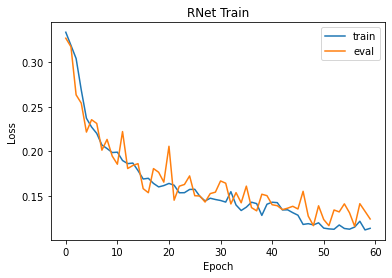

In [10]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('RNet Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()